<a href="https://colab.research.google.com/github/gmargonato/ML_Projects/blob/main/world_cup_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022 FIFA's Soccer World Cup

Dataset: https://www.kaggle.com/datasets/shilongzhuang/soccer-world-cup-challenge

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab.data_table import DataTable
DataTable.max_columns = 100

In [ ]:
!pip install pycaret
import pycaret
print('PyCaret: %s' % pycaret.__version__)
from pycaret.classification import *

In [ ]:
# Connection to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Acquisition
Loading the Datasets

In [ ]:
# Load all datasets from folder

# Using glob to get all the csv files in the folder
path = "/content/drive/MyDrive/ML Projects/2022 World Cup/dataset"
csv_files = glob.glob(os.path.join(path, "*.csv")) 

# Dictionary with original datasets
d = {}

# Loop over the list of csv files
for file in csv_files:

    filename = (file.split("/")[-1]).split(".")[0]

    #Read the csv file
    d[filename] = pd.read_csv(file)

    #Print the file name and content
    print(filename)
    display(d[filename].tail())
    print()

world_cup_matches


,ID,Year,Date,Stage,Home Team,Home Goals,Away Goals,Away Team,Winning Team,Losing Team,Win Conditions,Host Team
895,896,2018,2018/7/7,Quarter-finals,Russia,2,2,Croatia,NaN,NaN,Croatia win on penalties (3 - 4),True
896,897,2018,2018/7/10,Semi-finals,France,1,0,Belgium,France,Belgium,NaN,False
897,898,2018,2018/7/11,Semi-finals,Croatia,2,1,England,Croatia,England,Extra time,False
898,899,2018,2018/7/14,Third place,Belgium,2,0,England,Belgium,England,NaN,False
899,900,2018,2018/7/15,Final,France,4,2,Croatia,France,Croatia,NaN,False



2022_world_cup_matches


,ID,Year,Date,Stage,Home Team,Away Team,Host Team
59,60,2022,2022/12/10,Quarter-finals,W55,W56,NaN
60,61,2022,2022/12/13,Semi-finals,W57,W58,NaN
61,62,2022,2022/12/14,Semi-finals,W59,W60,NaN
62,63,2022,2022/12/17,Third place,L61,L62,NaN
63,64,2022,2022/12/18,Final,W61,W62,NaN



world_cups


,Year,Host Country,Winner,Runners-Up,Third,Fourth,Goals Scored,Qualified Teams,Matches Played
17,2006,Germany,Italy,France,Germany,Portugal,147.0,32,64
18,2010,South Africa,Spain,Netherlands,Germany,Uruguay,145.0,32,64
19,2014,Brazil,Germany,Argentina,Netherlands,Brazil,171.0,32,64
20,2018,Russia,France,Croatia,Belgium,England,169.0,32,64
21,2022,Qatar,NaN,NaN,NaN,NaN,NaN,32,64



international_matches


,ID,Tournament,Date,Home Team,Home Goals,Away Goals,Away Team,Winning Team,Losing Team,Win Conditions,Home Stadium
17764,17765,Friendly,2022/9/27,Qatar,2,2,Chile,NaN,NaN,NaN,False
17765,17766,Friendly,2022/9/27,Saudi Arabia,0,0,United States,NaN,NaN,NaN,False
17766,17767,UEFA Nations League,2022/9/27,Portugal,0,1,Spain,Spain,Portugal,NaN,True
17767,17768,UEFA Nations League,2022/9/27,Switzerland,2,1,Czech Republic,Switzerland,Czech Republic,NaN,True
17768,17769,UEFA Nations League,2022/9/27,Norway,0,2,Serbia,Serbia,Norway,NaN,True



2022_world_cup_groups


,Group,Team,FIFA Ranking
27,G,Cameroon,43
28,H,Portugal,9
29,H,Ghana,61
30,H,Uruguay,14
31,H,South Korea,28



data_dictionary


,Table,Field,Description
33,international_matches,Home Goals,Goals scored by the home team
34,international_matches,Away Goals,Goals scored by the away team
35,international_matches,Away Team,Country playing as the away team
36,international_matches,Win Conditions,Was the match decided by penalties?
37,international_matches,Home Stadium,TRUE whenever the game took place in the home ...


# Data Exploration

## world_cups

In [ ]:
df_world_cups = d['world_cups'].copy()
df_world_cups.tail()

,Year,Host Country,Winner,Runners-Up,Third,Fourth,Goals Scored,Qualified Teams,Matches Played
17,2006,Germany,Italy,France,Germany,Portugal,147.0,32,64
18,2010,South Africa,Spain,Netherlands,Germany,Uruguay,145.0,32,64
19,2014,Brazil,Germany,Argentina,Netherlands,Brazil,171.0,32,64
20,2018,Russia,France,Croatia,Belgium,England,169.0,32,64
21,2022,Qatar,NaN,NaN,NaN,NaN,NaN,32,64


In [ ]:
# Handling null values
df_world_cups.dropna(subset=['Winner'], inplace = True)

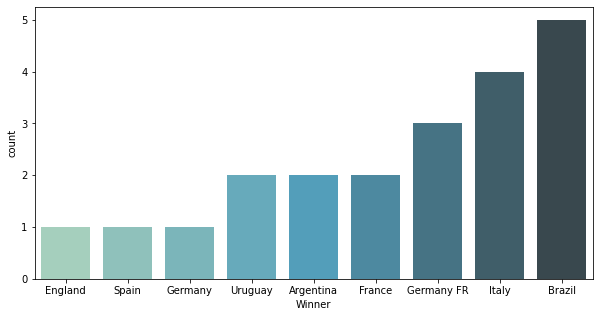

In [ ]:
# Number of times each country won the cup

plt.figure(figsize=(10,5))

sns.countplot(
    data = df_world_cups,
    x = 'Winner',
    order = df_world_cups.Winner.value_counts(ascending=True).index,
    palette = "GnBu_d"
)

plt.show()

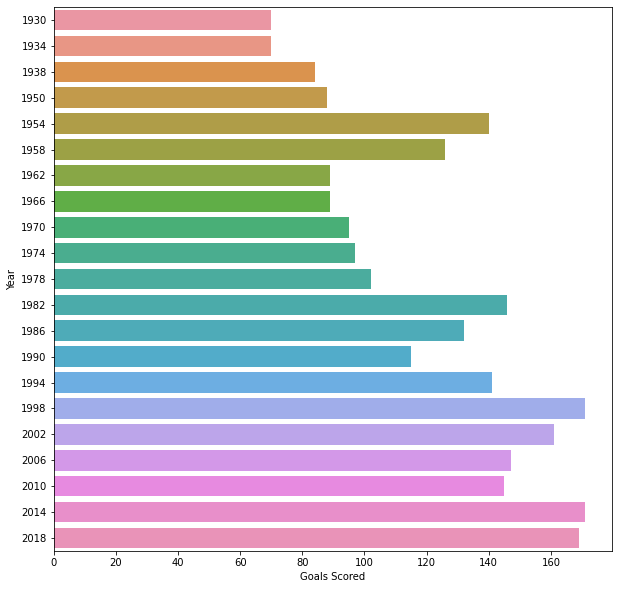

In [ ]:
# Sum of goals scored per cup edition

plt.figure(figsize=(10,10))
sns.barplot(
    data = df_world_cups,
    x = 'Goals Scored', 
    y = df_world_cups.Year.astype(str)
)
plt.show()


From the chart above, we can see a growth trend in goals scored per cup, and by using the gradient, I will group the years in periods of 7 cups to analyze outliers.

In [ ]:
# Grouping up

df_world_cups2 = df_world_cups[['Year','Goals Scored']].copy()

df_world_cups2.insert(0,'Era','')
df_world_cups2['Era'] = np.where(
    df_world_cups2['Year'] <= 1962, 
    1, 
    np.where(
        (df_world_cups2['Year'] >= 1962) & (df_world_cups2['Year'] <= 1990), 
        2, 
        3
    )
)

In [ ]:
# Box-Plot analysis

df_world_cups2.groupby("Era").boxplot(column="Goals Scored", figsize=(8,8));

Surprisingly enough, the '54 and the '82 cups were **not** considered outliers inside their respective groups

In [ ]:
# Influence of playing home

df_world_cups3 = df_world_cups[['Host Country','Winner','Runners-Up','Third']].copy()

# Renaming columns
df_world_cups3.rename(
    columns={
        'Host Country': 'Host', 
        'Winner': 'First', 
        'Runners-Up' : 'Second'
    }, 
    inplace=True
)

# Check if final placement equals host
for col in ['First','Second','Third']:
    df_world_cups3[col] = np.where(df_world_cups3['Host'] == df_world_cups3[col], 1, 0)

# New row summarizing columns
df_world_cups3.append(df_world_cups3.sum(numeric_only=True).rename('Total')).tail(1)

Throughout 20 cups, the hosting country:
- went 10 times to the podium (50%)
- won first place 5 times (25%)

## 2022_world_cup_groups

In [ ]:
world_cup_groups = d['2022_world_cup_groups'].copy()
world_cup_groups.sort_values(by=['FIFA Ranking'], inplace = True)
world_cup_groups.tail()

In [ ]:
world_cup_groups.plot(
    kind = 'bar', 
    figsize=(15,7), 
    x='Team', 
    y='FIFA Ranking', 
    rot = 45,
    title = 'FIFA 2022 Ranking - Leftmost is Actually Higher Classification',
)

## world_cup_matches

In [ ]:
df_world_cup_matches = d['world_cup_matches'].copy()

df_world_cup_matches = df_world_cup_matches[
    ['Year','Stage','Home Team','Home Goals','Away Goals','Away Team','Winning Team','Win Conditions']
]

df_world_cup_matches.tail(5)

,Year,Stage,Home Team,Home Goals,Away Goals,Away Team,Winning Team,Win Conditions
895,2018,Quarter-finals,Russia,2,2,Croatia,NaN,Croatia win on penalties (3 - 4)
896,2018,Semi-finals,France,1,0,Belgium,France,NaN
897,2018,Semi-finals,Croatia,2,1,England,Croatia,Extra time
898,2018,Third place,Belgium,2,0,England,Belgium,NaN
899,2018,Final,France,4,2,Croatia,France,NaN


Year                0
Stage               0
Home Team           0
Home Goals          0
Away Goals          0
Away Team           0
Winning Team      199
Win Conditions    838
dtype: int64

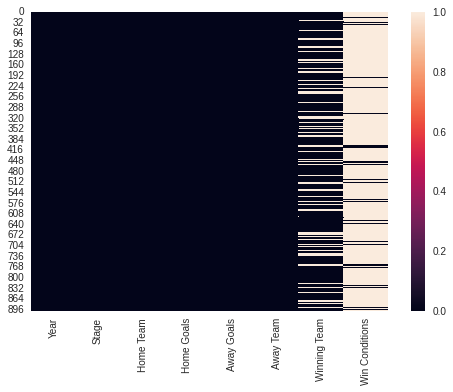

In [ ]:
# Checking for missing values

sns.heatmap(df_world_cup_matches.isna())

pd.isnull(df_world_cup_matches).sum()

### Data Cleaning

In [ ]:
# Auxiliar columns based on win conditions

df_world_cup_matches['aux1'] = df_world_cup_matches['Win Conditions'].str.split("win", expand=True)[0]
df_world_cup_matches['aux1'] = df_world_cup_matches['aux1'].str.replace(' ', '')

df_world_cup_matches['aux2'] = df_world_cup_matches['Win Conditions'].str.split("win", expand=True)[1]
df_world_cup_matches['aux2'] = df_world_cup_matches['aux2'].str.replace(' ', '')

In [ ]:
# Missing Winning Team
df_world_cup_matches['Winning Team'] = np.where(
    df_world_cup_matches['Winning Team'].isnull(),
    (np.where(df_world_cup_matches['aux1'].isnull(), 'Draw',df_world_cup_matches['aux1'])),
    df_world_cup_matches['Winning Team']
)

# Remove leading and trailing whitespace
df_world_cup_matches['Winning Team'] = df_world_cup_matches['Winning Team'].str.strip()
df_world_cup_matches.tail()

,Year,Stage,Home Team,Home Goals,Away Goals,Away Team,Winning Team,Win Conditions,aux1,aux2
895,2018,Quarter-finals,Russia,2,2,Croatia,Croatia,Croatia win on penalties (3 - 4),Croatia,onpenalties(3-4)
896,2018,Semi-finals,France,1,0,Belgium,France,NaN,NaN,NaN
897,2018,Semi-finals,Croatia,2,1,England,Croatia,Extra time,Extratime,None
898,2018,Third place,Belgium,2,0,England,Belgium,NaN,NaN,NaN
899,2018,Final,France,4,2,Croatia,France,NaN,NaN,NaN


In [ ]:
# Creating new variables for Penalties

df_world_cup_matches['Won on Penalties'] = np.where(
    df_world_cup_matches['aux2'].str.contains("penalties", case=False, na=False), 1, 0
)

df_world_cup_matches['Home Penalties'] = np.where(
    df_world_cup_matches['Won on Penalties'] != 0, 
    df_world_cup_matches['aux2'].str.slice(12, 13), #if true 
    0 #if false
)
df_world_cup_matches['Home Penalties'] = df_world_cup_matches['Home Penalties'].apply(int)

df_world_cup_matches['Away Penalties'] = np.where(
    df_world_cup_matches['Won on Penalties'] != 0, 
    df_world_cup_matches['aux2'].str.slice(14, 15), #if true 
    0 #if false
)
df_world_cup_matches['Away Penalties'] = df_world_cup_matches['Away Penalties'].apply(int)

df_world_cup_matches.tail()

,Year,Stage,Home Team,Home Goals,Away Goals,Away Team,Winning Team,Win Conditions,aux1,aux2,Won on Penalties,Home Penalties,Away Penalties
895,2018,Quarter-finals,Russia,2,2,Croatia,Croatia,Croatia win on penalties (3 - 4),Croatia,onpenalties(3-4),1,3,4
896,2018,Semi-finals,France,1,0,Belgium,France,NaN,NaN,NaN,0,0,0
897,2018,Semi-finals,Croatia,2,1,England,Croatia,Extra time,Extratime,None,0,0,0
898,2018,Third place,Belgium,2,0,England,Belgium,NaN,NaN,NaN,0,0,0
899,2018,Final,France,4,2,Croatia,France,NaN,NaN,NaN,0,0,0


In [ ]:
# Drop unnecessary columns
df_world_cup_matches.drop(columns=['Win Conditions','aux1','aux2'], inplace=True)

In [ ]:
# Check data types
print(df_world_cup_matches.info(), "\n")

# Check Nulls
print(pd.isnull(df_world_cup_matches).sum(), "\n")

# Print
display(df_world_cup_matches.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Year              900 non-null    int64 
 1   Stage             900 non-null    object
 2   Home Team         900 non-null    object
 3   Home Goals        900 non-null    int64 
 4   Away Goals        900 non-null    int64 
 5   Away Team         900 non-null    object
 6   Winning Team      900 non-null    object
 7   Won on Penalties  900 non-null    int64 
 8   Home Penalties    900 non-null    int64 
 9   Away Penalties    900 non-null    int64 
dtypes: int64(6), object(4)
memory usage: 70.4+ KB
None 

Year                0
Stage               0
Home Team           0
Home Goals          0
Away Goals          0
Away Team           0
Winning Team        0
Won on Penalties    0
Home Penalties      0
Away Penalties      0
dtype: int64 



,Year,Stage,Home Team,Home Goals,Away Goals,Away Team,Winning Team,Won on Penalties,Home Penalties,Away Penalties
895,2018,Quarter-finals,Russia,2,2,Croatia,Croatia,1,3,4
896,2018,Semi-finals,France,1,0,Belgium,France,0,0,0
897,2018,Semi-finals,Croatia,2,1,England,Croatia,0,0,0
898,2018,Third place,Belgium,2,0,England,Belgium,0,0,0
899,2018,Final,France,4,2,Croatia,France,0,0,0


### Data Engineering

In [ ]:
# Home Team

df_world_cup_matches_aux_1 = df_world_cup_matches[
    ['Year','Stage','Home Team','Home Goals','Winning Team','Won on Penalties','Home Penalties']
].copy()

df_world_cup_matches_aux_1.rename(
    columns={'Home Team': 'Team', 'Home Goals': 'Goals', 'Winning Team':'Winner','Won on Penalties':'Extension','Home Penalties': 'Penalties'}, 
    inplace=True
)

df_world_cup_matches_aux_1['Winner'] = np.where(
    df_world_cup_matches_aux_1['Team'] == df_world_cup_matches_aux_1['Winner'], 1, 0
)

# Away Team

df_world_cup_matches_aux_2 = df_world_cup_matches[
    ['Year','Stage','Away Team','Away Goals','Winning Team','Won on Penalties','Away Penalties']
].copy()

df_world_cup_matches_aux_2.rename(
    columns={'Away Team': 'Team', 'Away Goals': 'Goals', 'Winning Team':'Winner','Won on Penalties':'Extension','Away Penalties': 'Penalties'}, 
    inplace=True
)

df_world_cup_matches_aux_2['Winner'] = np.where(
    df_world_cup_matches_aux_2['Team'] == df_world_cup_matches_aux_2['Winner'], 1, 0
)

# Append

goals_per_team = df_world_cup_matches_aux_1.append(df_world_cup_matches_aux_2, ignore_index=True)

#Clear memory
del df_world_cup_matches_aux_1
del df_world_cup_matches_aux_2

In [ ]:
# Summarize

#goals_per_team_sum = goals_per_team.groupby(['Year','Stage', 'Team']).agg(
#    Goals       = ('Goals', 'sum'), 
#    Penalties   = ('Penalties', 'sum')
#).reset_index() 

#goals_per_team_sum.tail(10)

In [ ]:
# Now we are going to convert the stages into numbers, so we can plot a **scatterplot** with goals. This way we can understand the performance of each team throughout the Cup
goals_per_team['Stage'].unique()

array(['Group stage', 'Semi-finals', 'Final', 'Round of 16',
       'Quarter-finals', 'Third place', 'First round', 'Final round',
       'First group stage', 'Second group stage'], dtype=object)

In [ ]:
# Dictionary to help understand and sort Stages

stages_dict = {
    'First group stage'     : "0_First_Group_Stage", 
    'First round'           : "1_First_Round",
    'Second group stage'    : "2_Second_Group_Stage", 
    'Final round'           : "3_Final_Round",
    'Group stage'           : "4_Group_Stage", 
    'Round of 16'           : "5_Round_16",
    'Quarter-finals'        : "6_Quarter_Finals",    
    'Semi-finals'           : "7_Semi_Finals",   
    'Third place'           : "8_Third_Place",   
    'Final'                 : "9_Final",
}

goals_per_team.replace({'Stage': stages_dict}, inplace = True)
goals_per_team = goals_per_team.sort_values(by=['Year','Stage','Winner']).reset_index(drop = True)
goals_per_team.tail(15)

,Year,Stage,Team,Goals,Winner,Extension,Penalties
1785,2018,6_Quarter_Finals,Brazil,1,0,0,0
1786,2018,6_Quarter_Finals,Sweden,0,0,0,0
1787,2018,6_Quarter_Finals,Russia,2,0,1,3
1788,2018,6_Quarter_Finals,France,2,1,0,0
1789,2018,6_Quarter_Finals,Belgium,2,1,0,0
1790,2018,6_Quarter_Finals,England,2,1,0,0
1791,2018,6_Quarter_Finals,Croatia,2,1,1,4
1792,2018,7_Semi_Finals,Belgium,0,0,0,0
1793,2018,7_Semi_Finals,England,1,0,0,0
1794,2018,7_Semi_Finals,France,1,1,0,0


In [ ]:
(goals_per_team[goals_per_team["Team"] == 'France']).tail(10)

,Year,Stage,Team,Goals,Winner,Extension,Penalties
1629,2014,4_Group_Stage,France,5,1,0,0
1652,2014,5_Round_16,France,2,1,0,0
1656,2014,6_Quarter_Finals,France,0,0,0,0
1726,2018,4_Group_Stage,France,0,0,0,0
1730,2018,4_Group_Stage,France,2,1,0,0
1737,2018,4_Group_Stage,France,1,1,0,0
1776,2018,5_Round_16,France,4,1,0,0
1788,2018,6_Quarter_Finals,France,2,1,0,0
1794,2018,7_Semi_Finals,France,1,1,0,0
1799,2018,9_Final,France,4,1,0,0


# Model Development

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics

## Encoding categorical columns

In [ ]:
goals_per_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       1800 non-null   int64 
 1   Stage      1800 non-null   object
 2   Team       1800 non-null   object
 3   Goals      1800 non-null   int64 
 4   Winner     1800 non-null   int64 
 5   Extension  1800 non-null   int64 
 6   Penalties  1800 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 98.6+ KB


In [ ]:
#categorical data
categorical_cols = ['Stage', 'Team'] 

#import pandas as pd
df = pd.get_dummies(goals_per_team, columns = categorical_cols)

In [ ]:
column_to_move = df.pop("Winner")
df.insert(len(df.columns), "Winner", column_to_move)
df.tail(10)

,Year,Goals,Extension,Penalties,Stage_0_First_Group_Stage,Stage_1_First_Round,Stage_2_Second_Group_Stage,Stage_3_Final_Round,Stage_4_Group_Stage,Stage_5_Round_16,Stage_6_Quarter_Finals,Stage_7_Semi_Finals,Stage_8_Third_Place,Stage_9_Final,Team_Algeria,Team_Angola,Team_Argentina,Team_Australia,Team_Austria,Team_Belgium,Team_Bolivia,Team_Bosnia and Herzegovina,Team_Brazil,Team_Bulgaria,Team_Cameroon,Team_Canada,Team_Chile,Team_China,Team_Colombia,Team_Costa Rica,Team_Croatia,Team_Cuba,Team_Czech Republic,Team_Czechoslovakia,Team_DR Congo,Team_Denmark,Team_East Germany,Team_Ecuador,Team_Egypt,Team_El Salvador,Team_England,Team_France,Team_Germany,Team_Ghana,Team_Greece,Team_Haiti,Team_Honduras,Team_Hungary,Team_Iceland,Team_Indonesia,Team_Iran,Team_Iraq,Team_Israel,Team_Italy,Team_Ivory Coast,Team_Jamaica,Team_Japan,Team_Kuwait,Team_Mexico,Team_Morocco,Team_Netherlands,Team_New Zealand,Team_Nigeria,Team_North Korea,Team_Northern Ireland,Team_Norway,Team_Panama,Team_Paraguay,Team_Peru,Team_Poland,Team_Portugal,Team_Republic of Ireland,Team_Romania,Team_Russia,Team_Saudi Arabia,Team_Scotland,Team_Senegal,Team_Serbia,Team_Slovakia,Team_Slovenia,Team_South Africa,Team_South Korea,Team_Spain,Team_Sweden,Team_Switzerland,Team_Togo,Team_Trinidad and Tobago,Team_Tunisia,Team_Turkey,Team_Ukraine,Team_United Arab Emirates,Team_United States,Team_Uruguay,Team_Wales,Team_Yugoslavia,Winner
1790,2018,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1791,2018,2,1,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1792,2018,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1793,2018,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1794,2018,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1795,2018,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1796,2018,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1797,2018,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1798,2018,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1799,2018,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
#split dataset in features and target variable

X = df.loc[:, df.columns != 'Winner']   # Features
y = df.Winner                           # Target variable

In [ ]:
X.shape

(1800, 95)

In [ ]:
y

0       0
1       0
2       0
3       0
4       0
       ..
1795    1
1796    0
1797    1
1798    0
1799    1
Name: Winner, Length: 1800, dtype: int64

## Split Data into Train and Test

To understand model performance, dividing the dataset into a training set and a test set is necessary.

Let's split the dataset by using function `train_test_split()`.

In [ ]:
# Split dataset into 70% training and 30% for test

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.3, 
    random_state = 1
)

# PyCaret

PyCaret is a popular open-source library for machine learning in Python that helps users to train, tune, and deploy machine learning models quickly and easily. 

One of the main advantages of using PyCaret is that it automates many of the time-consuming tasks involved in building machine learning models, such as data preprocessing, feature engineering, model selection, and hyperparameter tuning. It also provides various tools and functions for visualizing and interpreting the results of machine learning models, which can be useful for understanding the underlying patterns and relationships in the data.

**We will only use PyCaret as a guide, and then built the recommended best model from scratch.**

In [ ]:
pycar = setup(df, target = 'Winner', train_size = 0.7, silent = True)

In [ ]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8126,0.8839,0.7466,0.7691,0.7567,0.6045,0.6056,0.161
ridge,Ridge Classifier,0.7959,0.0000,0.7181,0.7506,0.7328,0.5680,0.5693,0.012
lightgbm,Light Gradient Boosting Machine,0.7958,0.8803,0.6998,0.7598,0.7278,0.5650,0.5669,0.096
lda,Linear Discriminant Analysis,0.7943,0.8752,0.7161,0.7486,0.7308,0.5647,0.5660,0.028
ada,Ada Boost Classifier,0.7927,0.8625,0.7061,0.7498,0.7268,0.5602,0.5612,0.096
lr,Logistic Regression,0.7832,0.8773,0.7162,0.7263,0.7202,0.5433,0.5443,0.374
dt,Decision Tree Classifier,0.7578,0.7463,0.6814,0.6955,0.6876,0.4899,0.4907,0.017
rf,Random Forest Classifier,0.7577,0.8509,0.6855,0.6949,0.6888,0.4907,0.4920,0.220
et,Extra Trees Classifier,0.7315,0.7841,0.6510,0.6607,0.6547,0.4353,0.4362,0.203
knn,K Neighbors Classifier,0.7291,0.7934,0.5961,0.6740,0.6276,0.4178,0.4225,0.029


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=4390, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=4390, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Gradient Boosting Classifier had the overall best metrics, so let's go ahead and create this model

# GBC Model

To create the model, we will use the `GradientBoostingClassifier` class from `scikit learn` library

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# create the model with default parameter values
model = GradientBoostingClassifier(loss='deviance',
                                  learning_rate=0.1,
                                  n_estimators=100,
                                  subsample=1.0,
                                  criterion='friedman_mse',
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  min_weight_fraction_leaf=0.0,
                                  max_depth=3,
                                  min_impurity_decrease=0.0,
                                  min_impurity_split=None,
                                  init=None,
                                  random_state=None,
                                  max_features=None,
                                  verbose=0,
                                  max_leaf_nodes=None,
                                  warm_start=False,
                                  presort='auto',
                                  validation_fraction=0.1,
                                  n_iter_no_change=None,
                                  tol=0.0001)


In [ ]:
# train the model using the fit() method
model.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# make predictions on the test data
y_pred = model.predict(X_test)

## Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
# calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# calculate the precision of the model
precision = precision_score(y_test, y_pred)

# calculate the recall of the model
recall = recall_score(y_test, y_pred)

# calculate the f1 score of the model
f1 = f1_score(y_test, y_pred)

# print the evaluation metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.819
Precision: 0.775
Recall: 0.745
F1 score: 0.760


- **Accuracy:** Proportion of correct predictions made by the model. It is calculated by dividing the number of correct predictions by the total number of predictions.
<br>
- **Precision:** Proportion of positive predictions that are actually correct. It is calculated by dividing the number of true positives (TP) by the sum of the true positives and false positives (FP).
<br>
- **Recall:** Proportion of actual positive cases that were correctly predicted by the model. It is calculated by dividing the number of true positives by the sum of the true positives and false negatives (FN).
<br>
- **F1 score:** The F1 score is a measure of a model's balance between precision and recall. The F1 score ranges from 0 to 1, with a higher value indicating better performance.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

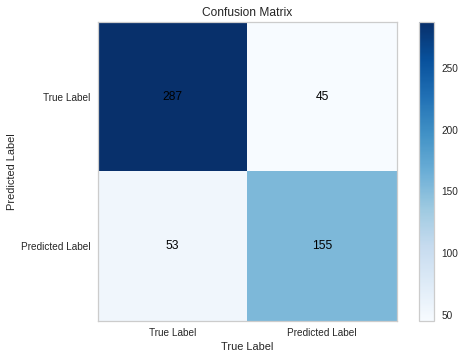

In [ ]:
# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix as a heatmap
plt.imshow(cm, cmap='Blues')

# remove the grid lines inside the plot
plt.grid(which='both', linewidth=0)

plt.colorbar()

# add labels to the plot
tick_marks = [i for i in range(2)]
class_labels = ['True Label', 'Predicted Label']
plt.yticks(tick_marks, class_labels)
plt.xticks(tick_marks, class_labels)

# add a title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')

# add the values to the plot
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

# show the plot
plt.show()


Our dataset originally had 1799 rows of data. The test subset consists of 540 rows, which is 30% of the original dataset:

**True positive (TP): 287**
<br>This is the number of cases where the model **correctly** predicted the positive class.

**False positive (FP): 45**
<br>This is the number of cases where the model incorrectly predicted the positive class.

**False negative (FN): 53**
<br>This is the number of cases where the model incorrectly predicted the negative class.

**True negative (TN): 155**
<br>This is the number of cases where the model **correctly** predicted the negative class.

# Model Deployment

It is generally recommended that the new dataset have the same structure as the training dataset, including the same number of columns and the same data types for each column. 

This is because the model was trained on a specific set of features, and changing the structure of the data can cause errors or lead to incorrect predictions.

In [ ]:
df_cup_2022 = d['2022_world_cup_matches']
df_cup_2022 = df_cup_2022[['ID','Stage', 'Home Team', 'Away Team']]

# Dictionary to help understand and sort Stages

df_cup_2022.replace({'Stage': stages_dict}, inplace = True)
#goals_per_team = goals_per_team.sort_values(by=['Year','Stage','Winner']).reset_index(drop = True)
#goals_per_team.tail(15)

display(df_cup_2022.head(30))
print()
display(df_cup_2022.tail(34))

,ID,Stage,Home Team,Away Team
0,1,4_Group_Stage,Qatar,Ecuador
1,2,4_Group_Stage,Senegal,Netherlands
2,3,4_Group_Stage,England,Iran
3,4,4_Group_Stage,United States,Wales
4,5,4_Group_Stage,France,Australia
5,6,4_Group_Stage,Denmark,Tunisia
6,7,4_Group_Stage,Mexico,Poland
7,8,4_Group_Stage,Argentina,Saudi Arabia
8,9,4_Group_Stage,Belgium,Canada
9,10,4_Group_Stage,Spain,Costa Rica


,ID,Stage,Home Team,Away Team
30,31,4_Group_Stage,Brazil,Switzerland
31,32,4_Group_Stage,Portugal,Uruguay
32,33,4_Group_Stage,England,Wales
33,34,4_Group_Stage,Iran,United States
34,35,4_Group_Stage,Ecuador,Senegal
35,36,4_Group_Stage,Qatar,Netherlands
36,37,4_Group_Stage,Denmark,Australia
37,38,4_Group_Stage,Tunisia,France
38,39,4_Group_Stage,Poland,Argentina
39,40,4_Group_Stage,Saudi Arabia,Mexico


Notes:

Gradient boosting classifier (GBC) is a machine learning algorithm that **is commonly used for classification tasks**. It works by building an ensemble of decision trees that are trained to predict the class label of an input sample.

To use GBC for regression, we will need to use a different implementation of the algorithm that is specifically designed for regression tasks. 

There are several libraries that provide implementations of GBC for regression, such as XGBoost and LightGBM.

___

Deploy the model:

Steps to follow in order to deploy a machine learning model into a new dataset:

1) Load the new dataset and the trained model.
Preprocess the new dataset using the same 

2) preprocessing steps as you used for the training data. This may include tasks such as cleaning the data, imputing missing values, encoding categorical variables, and scaling the features.

3) Use the trained model to make predictions on the preprocessed new dataset. This can typically be done using the predict() or predict_proba() method of the model, depending on the type of prediction you want to make.

4) Evaluate the performance of the model on the new data. You can use metrics such as accuracy, precision, recall, or F1 score to assess the model's performance.